# **Exploratory Data Analysis (EDA) for GARCH**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import  het_arch
from arch import arch_model

from sklearn.metrics import mean_squared_error


In [13]:
df = pd.read_csv('../data/clean/arima_data.csv',index_col='date', parse_dates=['date'])
df['returns'] = (df['close'].pct_change())*100
df['log_returns'] =  np.log(df['close'] / df['close'].shift(1))*100
df.dropna(inplace=True)

In [15]:
df.head()

,close,returns,log_returns
date,,,
2020-04-02,7874.30,-0.936999,-0.941417
2020-04-03,7764.33,-1.396569,-1.406412
2020-04-06,7747.64,-0.214957,-0.215189
2020-04-07,7743.91,-0.048144,-0.048155
2020-04-08,7722.16,-0.280866,-0.281261


In [17]:
df.tail()

,close,returns,log_returns
date,,,
2024-09-02,4344.26,0.117073,0.117004
2024-09-03,4343.16,-0.025321,-0.025324
2024-09-04,4361.62,0.425036,0.424135
2024-09-05,4384.90,0.533747,0.532327
2024-09-06,4411.85,0.614609,0.612728


In [19]:
df.describe()

,close,returns,log_returns
count,1115.000000,1115.000000,1115.000000
mean,5503.709076,-0.051940,-0.052800
std,695.250904,0.411428,0.411858
min,4339.180000,-2.093136,-2.115353
25%,5052.400000,-0.265178,-0.265530
50%,5436.870000,-0.021908,-0.021910
75%,5719.700000,0.180764,0.180601
max,7874.300000,2.537754,2.506088


In [21]:
y = df['log_returns']

C:\Users\azizb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


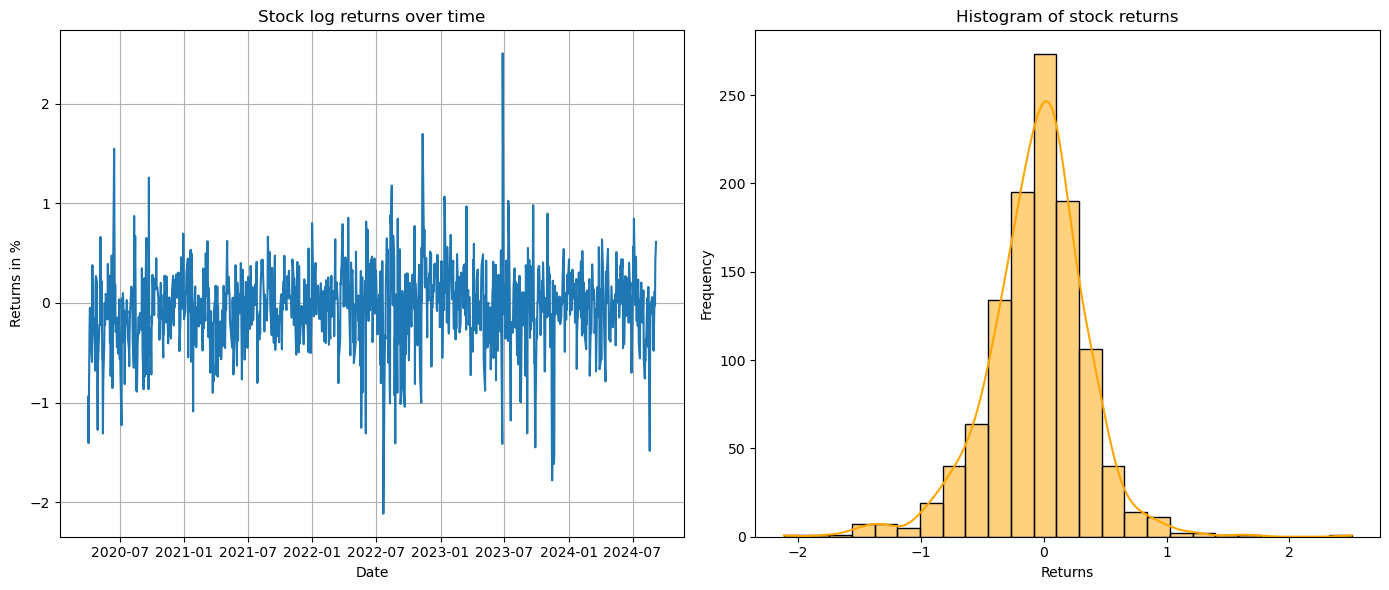

In [23]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.plot(y)
plt.xlabel('Date')
plt.ylabel('Returns in %')
plt.title('Stock log returns over time')
plt.grid(True)

plt.subplot(1,2,2)
sns.histplot(y,kde=True,bins=25,color='orange')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of stock returns')

plt.tight_layout()
plt.show()

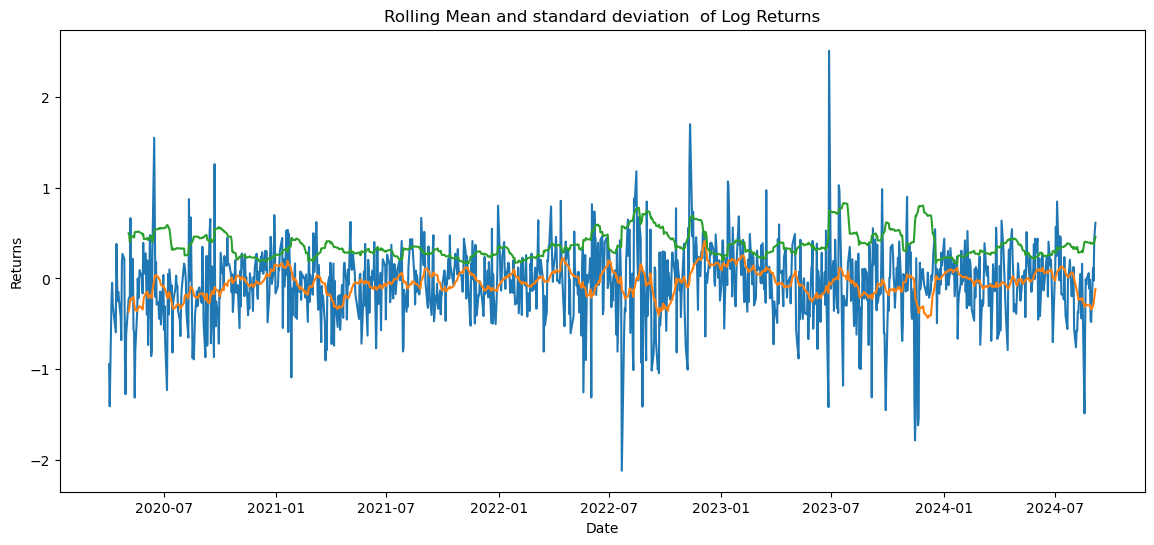

In [24]:
rolling_mean = y.rolling(window=20).mean()
rolling_std =  y.rolling(window=20).std()

plt.figure(figsize=(14,6))
plt.plot(y)
plt.plot(rolling_mean)
plt.plot(rolling_std)
plt.title('Rolling Mean and standard deviation  of Log Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

### ***Checking for GARCH model assumptions:***
- **Stationarity**

In [26]:
result = adfuller(y)

# Extract and display test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')

# Interpretation
if result[1] > 0.05:
    print("The series is non-stationary (fail to reject the null hypothesis).")
else:
    print("The series is stationary (reject the null hypothesis).")

ADF Statistic: -19.476808266857187
p-value: 0.0
Critical Values:
The series is stationary (reject the null hypothesis).


### ***Decision***

Using the augmented dickey fuller test with the graph plot of the returns over time 
- Log Returns are stationary

-  **Conditional Heteroskedasticity**

In [32]:
arch_test = het_arch(y)
print('ARCH Test p-value:', arch_test[1])

if arch_test[1]>0.05:
    print(f'since p-value {arch_test[1]} >0.05 we fail to reject the null hypothesis of homoskedasticity')
else: 
    print(f'since p-value {arch_test[1]} <0.05 we reject the null hypothesis of homoskedasticity')

ARCH Test p-value: 5.72626987545941e-16
since p-value 5.72626987545941e-16 <0.05 we reject the null hypothesis of homoskedasticity


## **Model Paramaters**

<Figure size 1000x600 with 0 Axes>

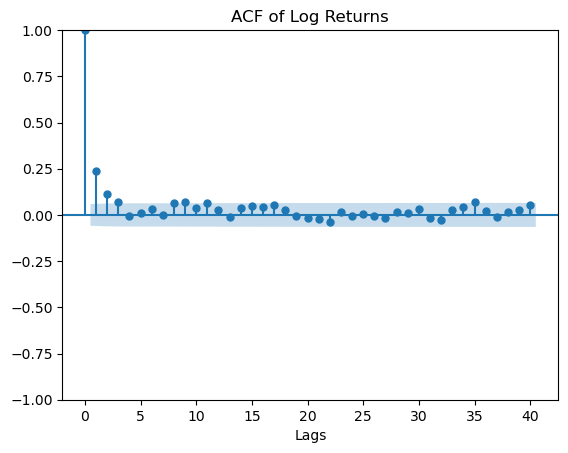

In [35]:
plt.figure(figsize=(10, 6))
plot_acf(y, lags=40)
plt.title('ACF of Log Returns')
plt.xlabel('Lags')
plt.show()




Text(0.5, 0, 'Lags')

<Figure size 1000x600 with 0 Axes>

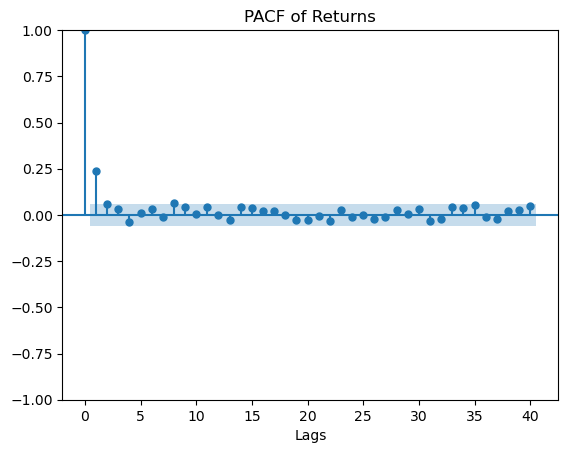

In [37]:
plt.figure(figsize=(10, 6))
plot_pacf(y, lags=40)
plt.title('PACF of Returns')
plt.xlabel('Lags')


### ***Decision***
Garch(1,1) model

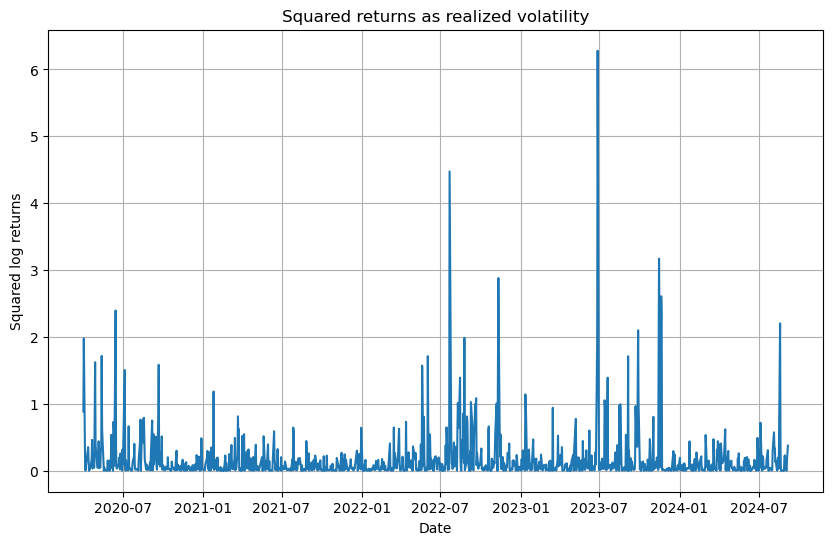

In [40]:
# Squared returns as realized volatility
realized_volatility = y**2

plt.figure(figsize=(10,6))
plt.plot(realized_volatility)
plt.xlabel('Date')
plt.ylabel('Squared log returns')
plt.title('Squared returns as realized volatility')
plt.grid(True)
plt.show()


In [41]:
# Split data train data 
cutoff = int(len(y)*0.8)
y_train = y[:cutoff]

# Baseline model
window = 4
y_pred_baseline = realized_volatility.rolling(window = window).mean().shift(1)
mse_baseline = mean_squared_error(realized_volatility[cutoff:],y_pred_baseline[cutoff:])
print(f'Mean Squared Error of the baseline Model: {mse_baseline}')

Mean Squared Error of the baseline Model: 0.1453969234418922


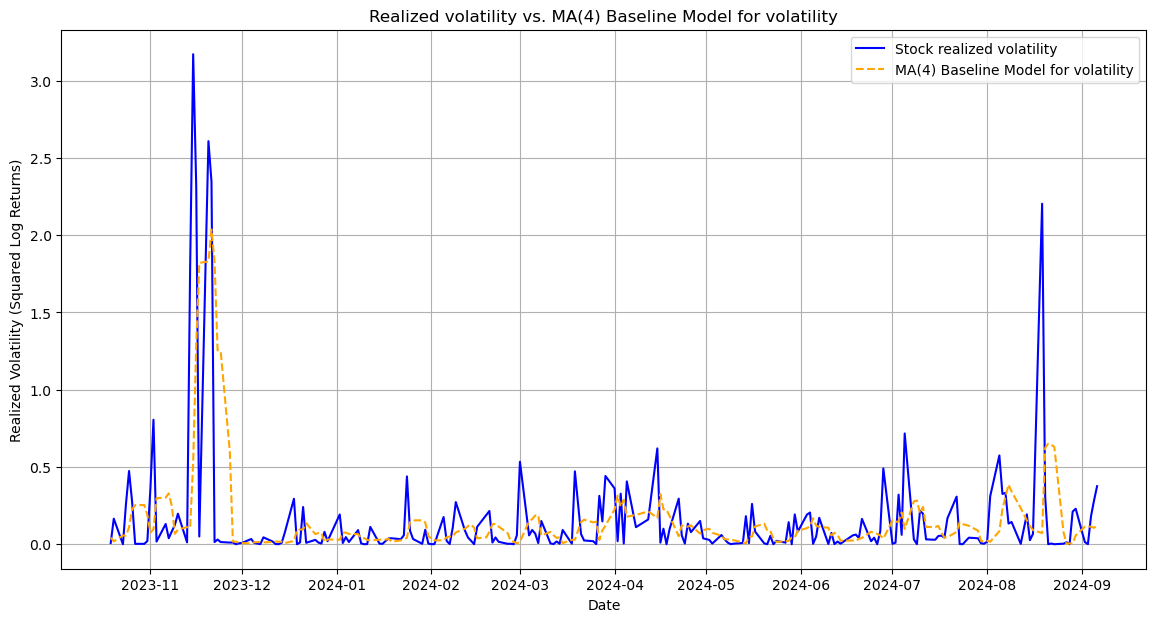

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(realized_volatility[cutoff:], label='Stock realized volatility', color='blue')

# Plot the Baseline predictions
plt.plot(y_pred_baseline[cutoff:], label='MA(4) Baseline Model for volatility', color='orange', linestyle='--')

# Adding labels and title
plt.title('Realized volatility vs. MA(4) Baseline Model for volatility')
plt.xlabel('Date')
plt.ylabel('Realized Volatility (Squared Log Returns)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [45]:
# use wfv 
predictions = pd.Series(dtype=float)
history = list(y_train)
for i in range(cutoff,len(y)):
    model = arch_model(history, vol='Garch', p=1, q=1).fit(disp='off')
    forecast = model.forecast()
    predictions[y.index[i]] = forecast.variance.iloc[-1].values[0]
    history.append(y.iloc[i])
mse_garch = mean_squared_error(realized_volatility[cutoff:],predictions)
print(f'Mean Squared Error of the baseline Model: {mse_garch}')

Mean Squared Error of the baseline Model: 0.13209469319651973


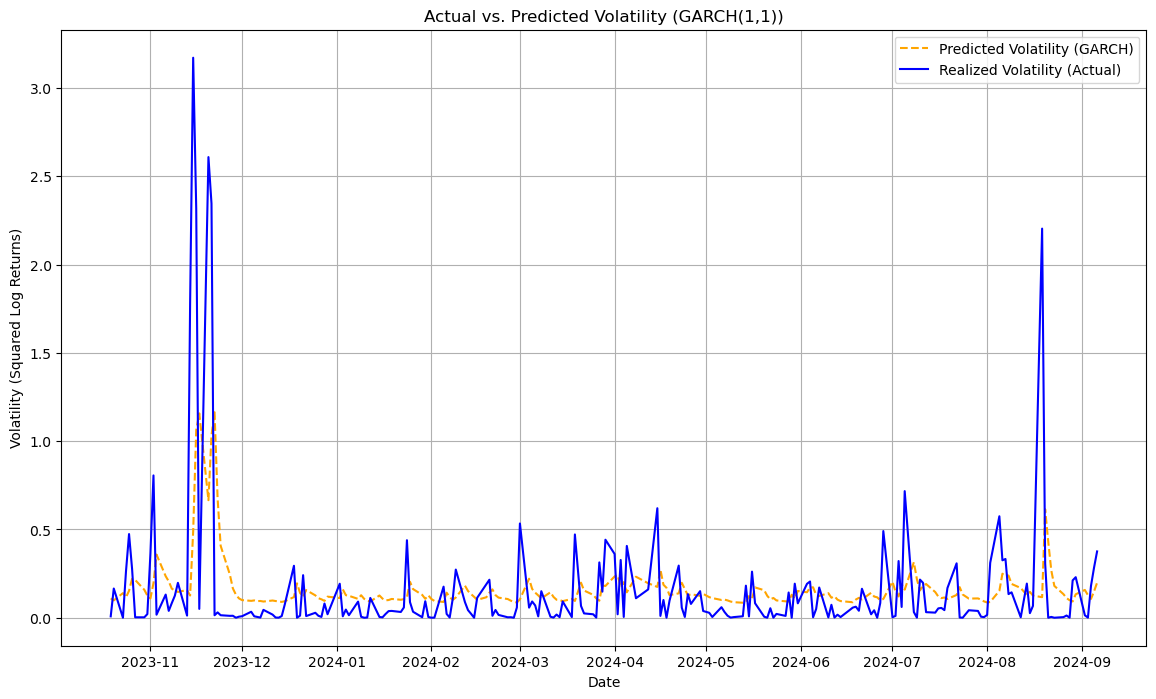

In [47]:
plt.figure(figsize=(14, 8))

# Plot GARCH predicted volatility (predictions)
plt.plot(predictions, label='Predicted Volatility (GARCH)', color='orange', linestyle='--')

# Plot actual realized volatility (squared log returns)
plt.plot(realized_volatility[cutoff:], label='Realized Volatility (Actual)', color='blue')

plt.title('Actual vs. Predicted Volatility (GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility (Squared Log Returns)')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -520.769
Distribution:                  Normal   AIC:                           1049.54
Method:            Maximum Likelihood   BIC:                           1069.60
                                        No. Observations:                 1114
Date:                Sat, Sep 07 2024   Df Residuals:                     1113
Time:                        18:56:39   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0378  1.238e-02     -3.056  2.240e-03 [-6.210e-02,-1.357e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0420  1.736e-02      2.422  1.544e-02 [8.017e-03,7.605e-02]
alpha[1]       0.2483  6.217e-02      3.994  6.493e-05     [  0.126,  0.370]
beta[1]        0.5064      0.153      3.303  9.566e-04     [  0.206,  0.807]
============================================================================

Covariance estimator: robust
"""